In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm
# prophet by Facebook
from fbprophet import Prophet
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# load data
df = pd.read_csv("../AuthentiChain/resources/gas_price_data_1year.csv", 
    index_col='timestamp',     
    parse_dates=True, 
    infer_datetime_format=True,
    header=0)

# summarize shape
print(df.shape)

# show first few rows
print(df.head())

(8760, 1)
                        gas_price
timestamp                        
2022-06-01 11:03:52   63239618198
2022-06-01 12:03:48   68281963048
2022-06-01 13:08:25  121007946512
2022-06-01 14:07:45  126156205023
2022-06-01 15:10:50   67510279000


In [3]:
# Resample the data into daily data, taking the mean gas price for each day
daily_gas_price_df = df.resample('D').last()
daily_gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354 entries, 2022-06-01 to 2023-05-20
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   gas_price  354 non-null    int64
dtypes: int64(1)
memory usage: 5.5 KB


In [4]:
# show first few rows
print(daily_gas_price_df.head())

              gas_price
timestamp              
2022-06-01  47331137724
2022-06-02  52125073354
2022-06-03  50925847852
2022-06-04  22076581780
2022-06-05  73286894729


In [5]:
daily_gas_price_df = daily_gas_price_df.reset_index()
daily_gas_price_df.head()

,timestamp,gas_price
0,2022-06-01,47331137724
1,2022-06-02,52125073354
2,2022-06-03,50925847852
3,2022-06-04,22076581780
4,2022-06-05,73286894729


In [6]:
daily_gas_price_df=daily_gas_price_df.rename(columns={'timestamp':'Date'})

In [7]:
daily_gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       354 non-null    datetime64[ns]
 1   gas_price  354 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.7 KB


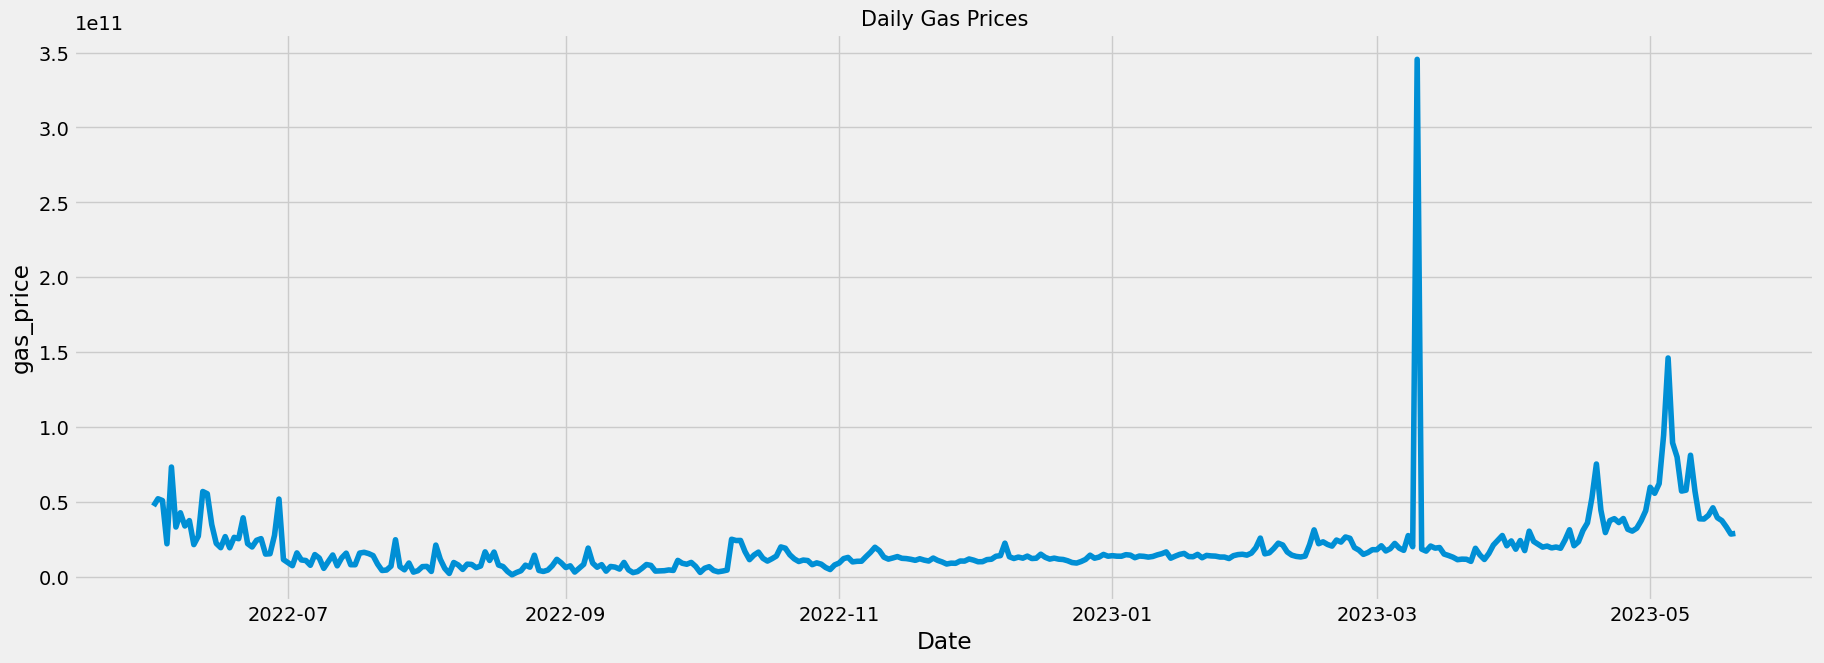

In [8]:
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="Date", y="gas_price", data=daily_gas_price_df)
a.set_title("Daily Gas Prices",fontsize=15)
plt.show()

Exploratory Data Analysis

In [9]:
def date_features(df, label=None):
    df = df.copy()

    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(daily_gas_price_df, label='gas_price')
df_new = pd.concat([X, y], axis=1)
df_new.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,gas_price
0,Wednesday,2,June,2022,152,1,22,47331137724
1,Thursday,2,June,2022,153,2,22,52125073354
2,Friday,2,June,2022,154,3,22,50925847852
3,Saturday,2,June,2022,155,4,22,22076581780
4,Sunday,2,June,2022,156,5,22,73286894729


Plotting the Features to see trends
Gas Prices does not show a strong seasonal properties.

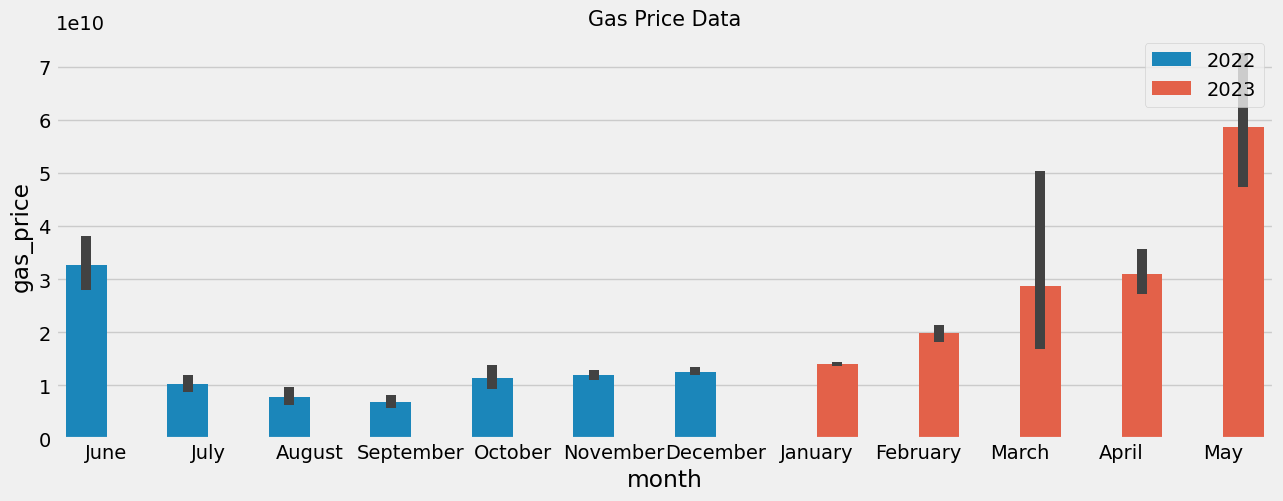

In [10]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="gas_price",hue = 'year',data=df_new)
a.set_title("Gas Price Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [11]:
daily_gas_price_df=daily_gas_price_df.rename(columns={'Date':'ds','gas_price':'y'})
daily_gas_price_df.head()

,ds,y
0,2022-06-01,47331137724
1,2022-06-02,52125073354
2,2022-06-03,50925847852
3,2022-06-04,22076581780
4,2022-06-05,73286894729


In [12]:
# Split data on train and test
split_point = int(len(daily_gas_price_df) * 0.8)

In [13]:
# Define train and test
train = daily_gas_price_df.iloc[:split_point]
test = daily_gas_price_df.iloc[split_point:]

In [14]:
train.head(), train.tail(), test.head(), test.tail()

(          ds            y
 0 2022-06-01  47331137724
 1 2022-06-02  52125073354
 2 2022-06-03  50925847852
 3 2022-06-04  22076581780
 4 2022-06-05  73286894729,
             ds             y
 278 2023-03-06   19175838970
 279 2023-03-07   17692492179
 280 2023-03-08   27535163537
 281 2023-03-09   20103434843
 282 2023-03-10  345457982351,
             ds            y
 283 2023-03-11  18499649803
 284 2023-03-12  17184959149
 285 2023-03-13  20551910234
 286 2023-03-14  19159255381
 287 2023-03-15  19572135213,
             ds            y
 349 2023-05-16  39454459644
 350 2023-05-17  37511919821
 351 2023-05-18  33310207590
 352 2023-05-19  28548516604
 353 2023-05-20  29012598570)

In [15]:
print("train shape",train.shape)
print("test shape",test.shape)

train shape (283, 2)
test shape (71, 2)


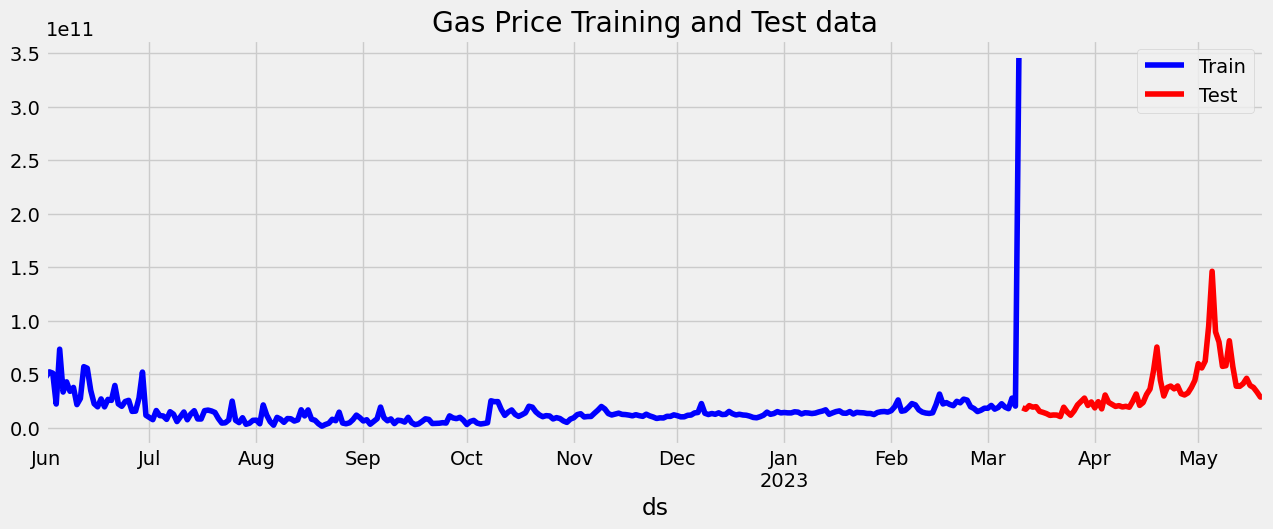

In [16]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Gas Price Training and Test data')
plt.show()

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
def RMSE(actual, pred):
    #return (sum((actual - pred)**2)/ len(actual))**0.5
    return (sum((actual - pred)**2)/ len(actual))**0.5

Simple Prophet Model

In [19]:
model=Prophet()
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


      99       653.065     0.0019539       51.5478      0.3673      0.3673      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       657.753   9.02949e-05        46.772   2.149e-06       0.001      294  LS failed, Hessian reset 
     198       657.756   4.15678e-06       29.9353   9.132e-08       0.001      351  LS failed, Hessian reset 
     199       657.756   5.24516e-06       45.4538       2.669      0.5478      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       657.765   1.02998e-05       50.1573   1.859e-07       0.001      447  LS failed, Hessian reset 
     280       657.769   8.72781e-08       41.5234   2.866e-09       0.001      555  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Predict forecast by creating future dataframe next dates on the training data.

In [20]:
# Python
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model_1.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model

In [21]:
future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
347,2023-05-14,4.887802e+10,2.389064e+10,7.456655e+10
348,2023-05-15,4.922194e+10,2.226139e+10,7.731465e+10
349,2023-05-16,4.988272e+10,2.482213e+10,7.444068e+10
350,2023-05-17,5.066649e+10,2.524845e+10,7.588249e+10
351,2023-05-18,4.979013e+10,2.252308e+10,7.394792e+10
352,2023-05-19,5.619211e+10,3.251750e+10,8.414383e+10
353,2023-05-20,4.719238e+10,2.166189e+10,7.203612e+10


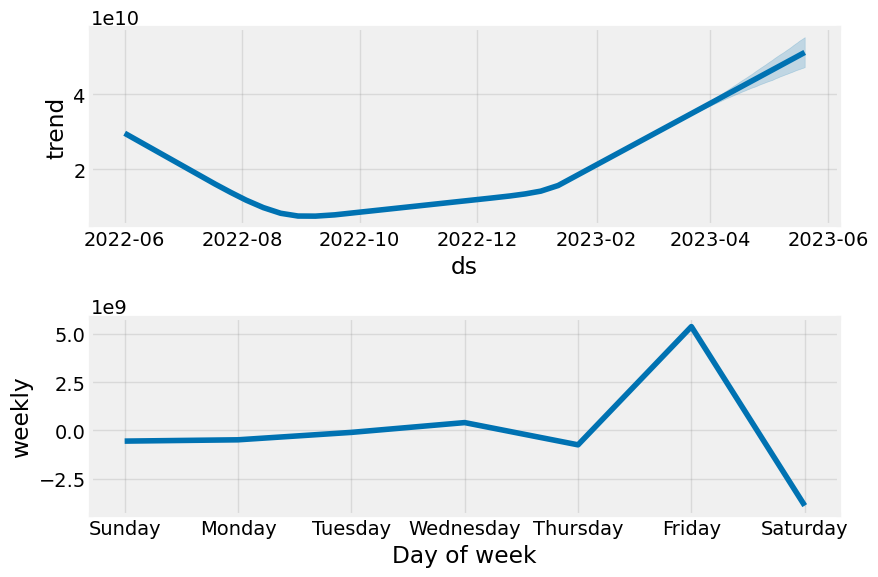

In [22]:
fig = model.plot_components(forecast)

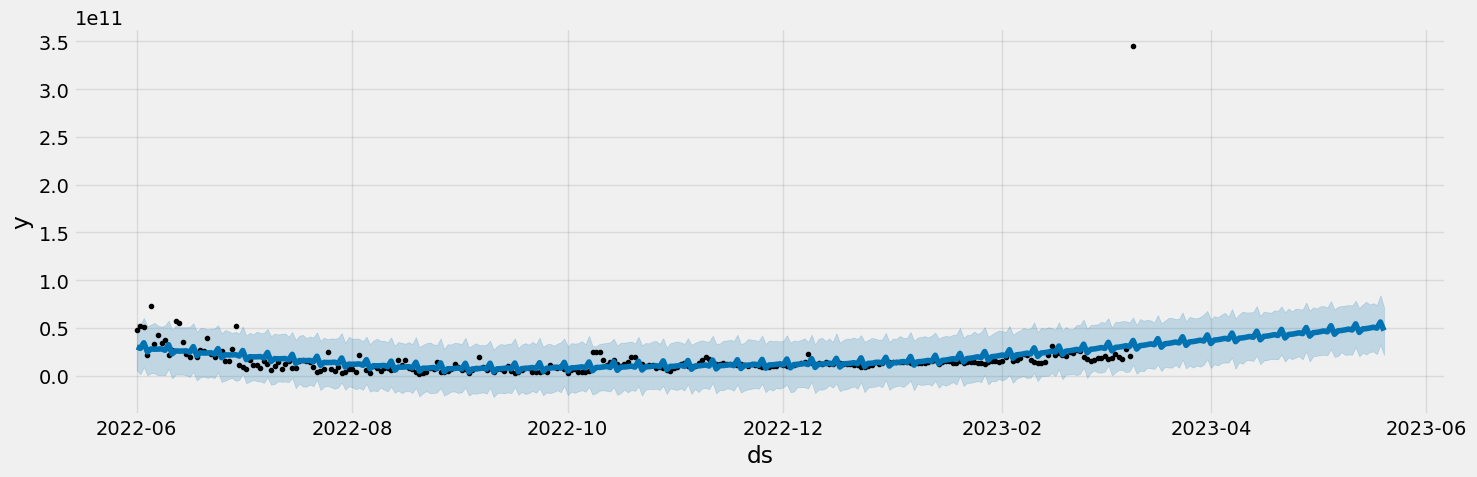

In [23]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

Actual vs Prediction Comparison

In [24]:
X_tst_forecast = model.predict(test)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
64,2023-05-14,4.887802e+10,2.402293e+10,7.615009e+10
65,2023-05-15,4.922194e+10,2.364578e+10,7.591939e+10
66,2023-05-16,4.988272e+10,2.261604e+10,7.510540e+10
67,2023-05-17,5.066649e+10,2.494323e+10,7.821572e+10
68,2023-05-18,4.979013e+10,2.441926e+10,7.467094e+10
69,2023-05-19,5.619211e+10,3.056377e+10,8.081940e+10
70,2023-05-20,4.719238e+10,1.995438e+10,7.329828e+10


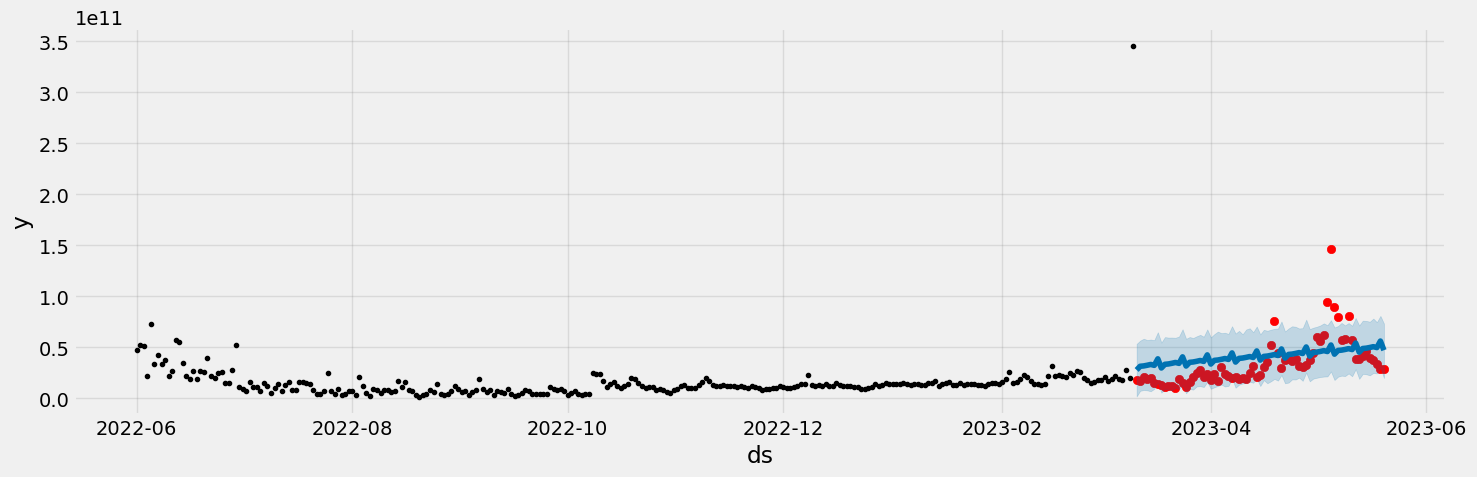

In [25]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.ds, test['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

Compare the test Gas Prices and forecasted Gas Prices

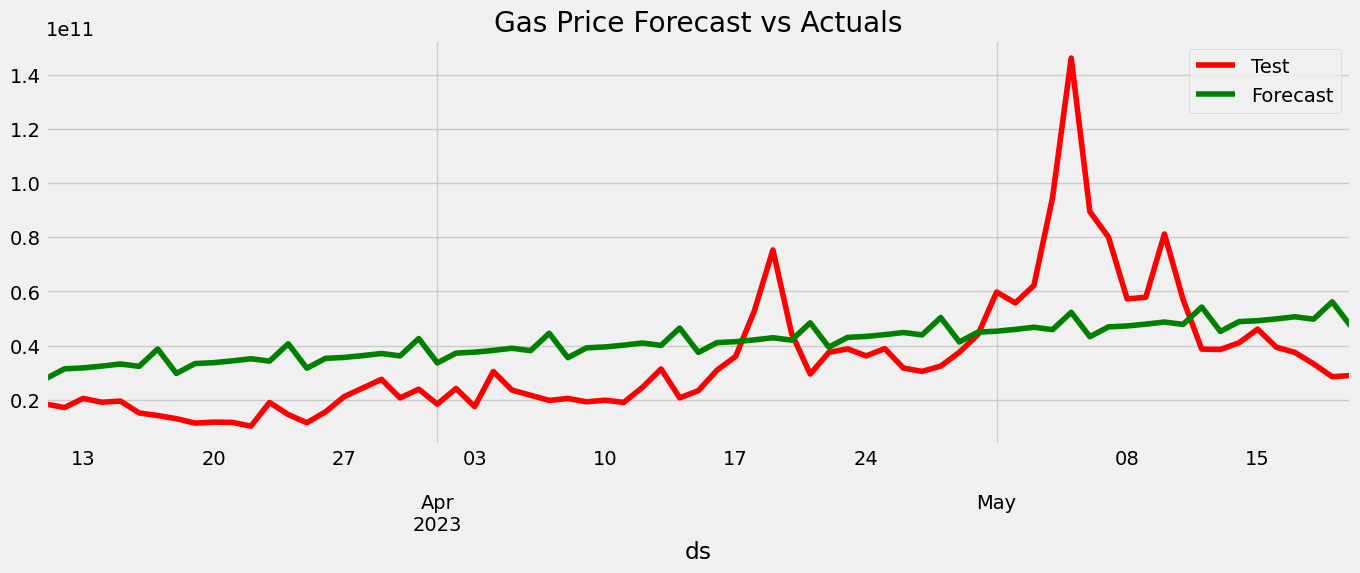

In [26]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Gas Price Forecast vs Actuals')
plt.show()

We can see from the above plot, that there is huge gap in prediction. So we need to optimize the model by adding other parameters like holidays, changepoints etc.

In [28]:
mape = mean_absolute_percentage_error(test['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 66.5169


Adding Holidays to the model

We will use holidays library to get the US holidays

In [30]:
import holidays

In [31]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [32]:
holiday.head()

,ds,holiday
0,2018-01-01,US-Holidays
1,2018-01-15,US-Holidays
2,2018-02-19,US-Holidays
3,2018-05-28,US-Holidays
4,2018-07-04,US-Holidays


In [33]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0085


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       653.065     0.0019539       51.5478      0.3673      0.3673      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       657.753   9.02949e-05        46.772   2.149e-06       0.001      294  LS failed, Hessian reset 
     198       657.756   4.15678e-06       29.9353   9.132e-08       0.001      351  LS failed, Hessian reset 
     199       657.756   5.24516e-06       45.4538       2.669      0.5478      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       657.765   1.02998e-05       50.1573   1.859e-07       0.001      447  LS failed, Hessian reset 
     280       657.769   8.72781e-08       41.5234   2.866e-09       0.001      555  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

In [34]:
future = model_with_holidays.make_future_dataframe(periods=len(test), freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
347,2023-05-14,4.887802e+10,2.468481e+10,7.596705e+10
348,2023-05-15,4.922194e+10,2.429652e+10,7.326123e+10
349,2023-05-16,4.988272e+10,2.601694e+10,7.719849e+10
350,2023-05-17,5.066649e+10,2.633933e+10,7.722551e+10
351,2023-05-18,4.979013e+10,2.596526e+10,7.517100e+10
352,2023-05-19,5.619211e+10,3.006928e+10,8.071787e+10
353,2023-05-20,4.719238e+10,2.154337e+10,7.371190e+10


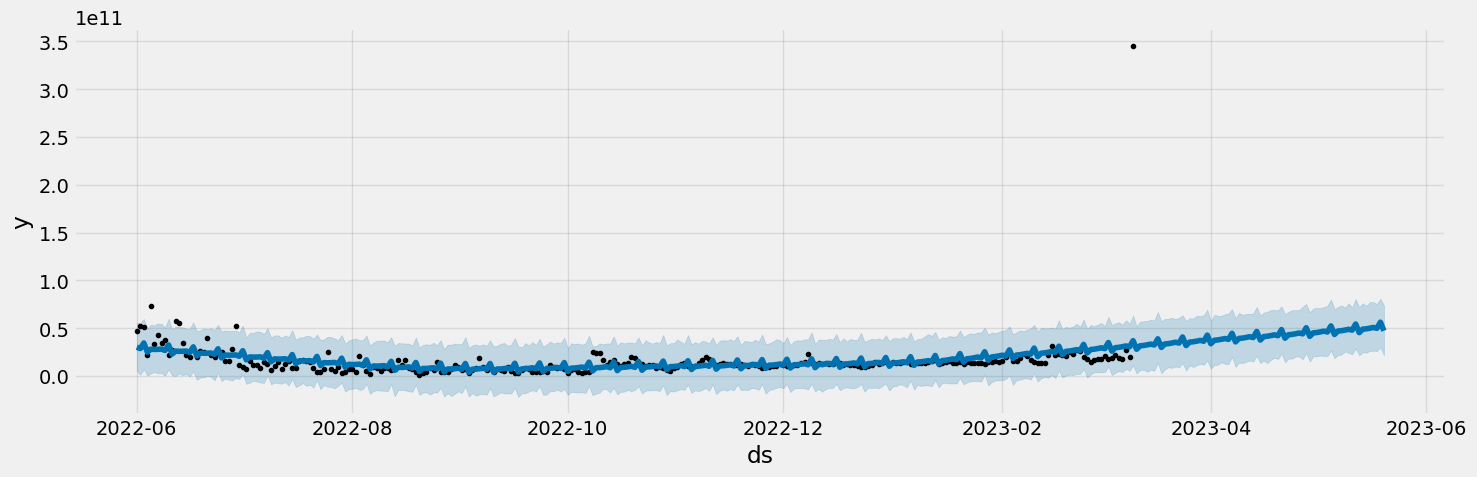

In [35]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

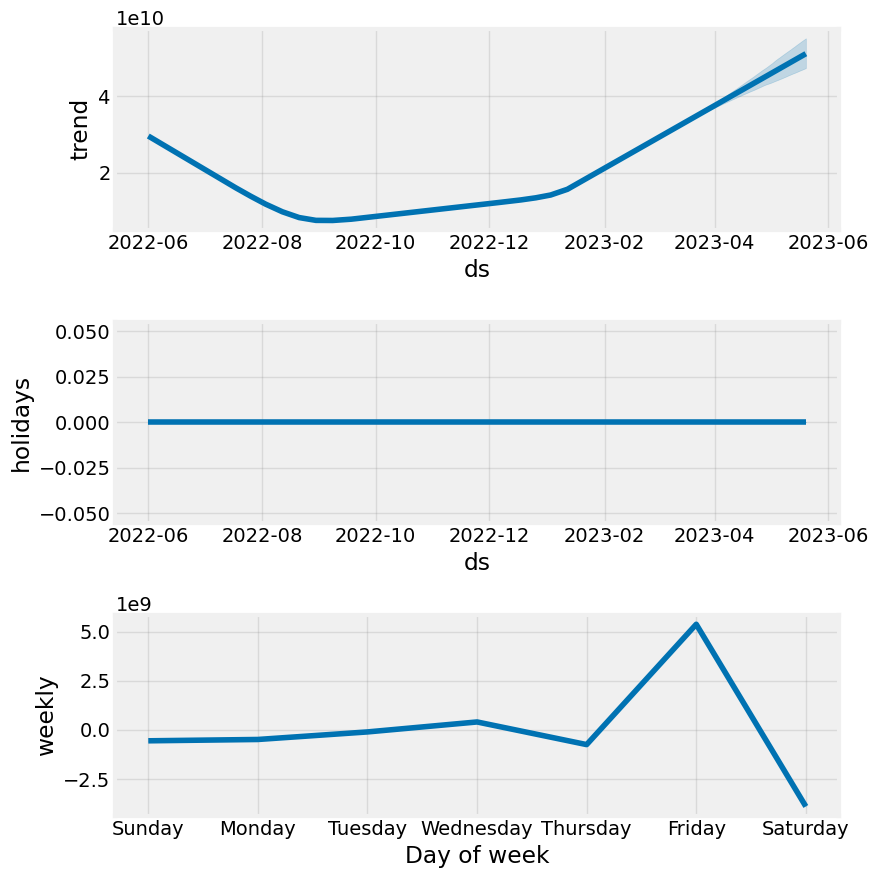

In [36]:
# Plot the components of the model
fig = model_with_holidays.plot_components(forecast)

In [37]:
X_tst_forecast_holiday = model_with_holidays.predict(test)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
64,2023-05-14,4.887802e+10,2.407931e+10,7.542488e+10
65,2023-05-15,4.922194e+10,2.280119e+10,7.358569e+10
66,2023-05-16,4.988272e+10,2.425764e+10,7.395257e+10
67,2023-05-17,5.066649e+10,2.542447e+10,7.866066e+10
68,2023-05-18,4.979013e+10,2.391902e+10,7.641400e+10
69,2023-05-19,5.619211e+10,3.119295e+10,8.194295e+10
70,2023-05-20,4.719238e+10,2.291416e+10,7.142695e+10


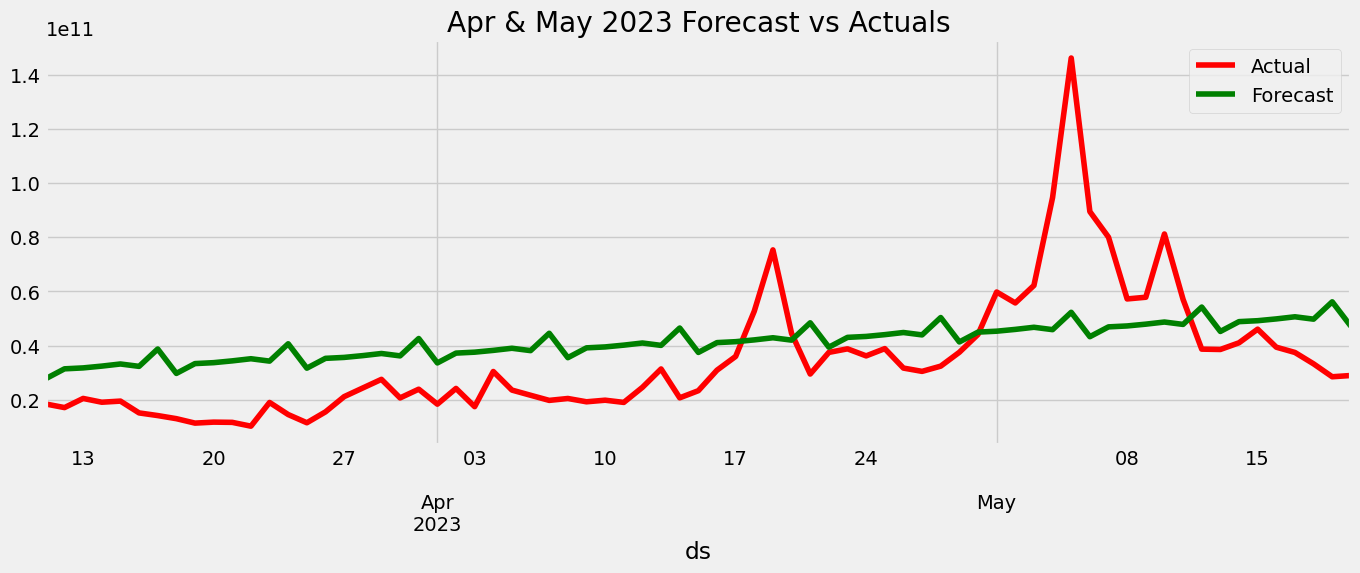

In [38]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Apr & May 2023 Forecast vs Actuals')
plt.show()

In [39]:
mape = mean_absolute_percentage_error(test['y'],X_tst_forecast_holiday['yhat'])
print("MAPE",round(mape,4))

MAPE 66.5169


From the above results, we can see that by adding holidays in the model, model performance was unchanged.  We need to add other parameters to tune the model.

linkcode
Along with holidays, there are many other hyperparameters which helps in optimizing the prophet model.

Holidays
Changepoints: (n_changepoints,changepoint_prior_scale)
seasonality_mode
holiday_prior_scale
Seasonalities with fourier_order
We have added holidays to our model and saw its effect.

n_changepoints is the number of change happen in the data. Prophet model detects them by its own. By default, its value is 25, which are uniformly placed in the first 80% of the time series. Changing n_changepoints can add value to the model.

changepoint_prior_scale to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If you make it high it will be more flexible, but you can end up overfitting. By default, this parameter is set to 0.05

seasonality_mode There are 2 types model seasonality mode. Additive & multiplicaticative. By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the model.

holiday_prior_scale just like changepoint_prior_scale, holiday_prior_scale is used to smoothning the effect of holidays. By default its value is 10, which provides very little regularization. Reducing this parameter dampens holiday effects

Seasonalities with fourier_order Prophet model, by default finds the seasonalities and adds the default parameters of the seasonality. We can modify the seasonalities effect by adding custom seasonalities as add_seasonality in the model with different fourier order.Yy default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.

Now, we will do the hyperparameters tuning using parametergrid. parametergrid will create all the possible parameters combination and will test the model prediction using every combination. I am taking 4 parameters: n_changepoints, changepoint_prior_scale,seasonality_mode, holiday_prior_scale for tuning.

In [55]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


Prophet Model Tuning

In [65]:
strt='2023-03-10'
end='2023-05-20'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test_df = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(test)
    train_forecast = train_model.make_future_dataframe(periods=len(test), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test_df=train_forecast[['ds','yhat']]
    Actual = daily_gas_price_df[(daily_gas_price_df['ds']>strt) & (daily_gas_price_df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test_df['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 55.



Initial log joint probability = -75.1411
Iteration  1. Log joint probability =    22.8864. Improved by 98.0275.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joint probability =    87.2462. Improved by 0.0510433.
Iteration 12. Log joint probability =    87.2808. Improved by 0.0345361.
Iteration 13. Log joint probability =    87.3252. Improved by 0.0444464.
Iteration 14. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 90491.65217307566
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -75.1411
Iteration  1. Log joint probability =    56.6306. Improved by 131.772.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.992345970821
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -75.1411
Iteration  1. Log joint probability =    22.8864. Improved by 98.0275.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 90491.65217307566
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -75.1411
Iteration  1. Log joint probability =    56.6306. Improved by 131.772.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.992345970821
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -75.1411
Iteration  1. Log joint probability =    22.8864. Improved by 98.0275.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 90491.65217307566
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -75.1411
Iteration  1. Log joint probability =    56.6306. Improved by 131.772.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.992345970821
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -84.8451
Iteration  1. Log joint probability =    22.8864. Improved by 107.732.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 92421.38149606404
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -84.8451
Iteration  1. Log joint probability =    56.6306. Improved by 141.476.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.992345964002
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -84.8451
Iteration  1. Log joint probability =    22.8864. Improved by 107.732.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 92421.38149606404
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -84.8451
Iteration  1. Log joint probability =    56.6306. Improved by 141.476.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.992345964002
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -84.8451
Iteration  1. Log joint probability =    22.8864. Improved by 107.732.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 92421.38149606404
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -84.8451
Iteration  1. Log joint probability =    56.6306. Improved by 141.476.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.992345964002
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -90.5216
Iteration  1. Log joint probability =    22.8864. Improved by 113.408.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 91621.37162278536
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -90.5216
Iteration  1. Log joint probability =    56.6306. Improved by 147.152.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.992345958634
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -90.5216
Iteration  1. Log joint probability =    22.8864. Improved by 113.408.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 91621.37162278536
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -90.5216
Iteration  1. Log joint probability =    56.6306. Improved by 147.152.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.992345958634
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -90.5216
Iteration  1. Log joint probability =    22.8864. Improved by 113.408.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 91621.37162278536
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -90.5216
Iteration  1. Log joint probability =    56.6306. Improved by 147.152.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.992345958634
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -94.5492
Iteration  1. Log joint probability =    22.8864. Improved by 117.436.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 93352.62493726877
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -94.5492
Iteration  1. Log joint probability =    56.6306. Improved by 151.18.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabili

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.99234603563
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -94.5492
Iteration  1. Log joint probability =    22.8864. Improved by 117.436.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log join

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 93352.62493726877
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -94.5492
Iteration  1. Log joint probability =    56.6306. Improved by 151.18.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabili

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.99234603563
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -94.5492
Iteration  1. Log joint probability =    22.8864. Improved by 117.436.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log join

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 93352.62493726877
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -94.5492
Iteration  1. Log joint probability =    56.6306. Improved by 151.18.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabili

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.99234603563
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -97.6732
Iteration  1. Log joint probability =    22.8864. Improved by 120.56.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joint

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 93405.06170058707
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -97.6732
Iteration  1. Log joint probability =    56.6306. Improved by 154.304.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.99234595421
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -97.6732
Iteration  1. Log joint probability =    22.8864. Improved by 120.56.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joint

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 93405.06170058707
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -97.6732
Iteration  1. Log joint probability =    56.6306. Improved by 154.304.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.99234595421
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -97.6732
Iteration  1. Log joint probability =    22.8864. Improved by 120.56.
Iteration  2. Log joint probability =    43.7263. Improved by 20.8399.
Iteration  3. Log joint probability =     67.813. Improved by 24.0867.
Iteration  4. Log joint probability =    87.0784. Improved by 19.2653.
Iteration  5. Log joint probability =    87.0838. Improved by 0.00543181.
Iteration  6. Log joint probability =    87.1035. Improved by 0.0197164.
Iteration  7. Log joint probability =    87.1147. Improved by 0.0111875.
Iteration  8. Log joint probability =    87.1417. Improved by 0.0269829.
Iteration  9. Log joint probability =    87.1625. Improved by 0.0207958.
Iteration 10. Log joint probability =    87.1952. Improved by 0.0326948.
Iteration 11. Log joint

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 93405.06170058707
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -97.6732
Iteration  1. Log joint probability =    56.6306. Improved by 154.304.
Iteration  2. Log joint probability =    104.597. Improved by 47.9662.
Iteration  3. Log joint probability =    125.952. Improved by 21.3553.
Iteration  4. Log joint probability =     134.01. Improved by 8.05825.
Iteration  5. Log joint probability =    136.423. Improved by 2.41281.
Iteration  6. Log joint probability =    136.925. Improved by 0.501525.
Iteration  7. Log joint probability =    136.938. Improved by 0.0137431.
Iteration  8. Log joint probability =    137.235. Improved by 0.296998.
Iteration  9. Log joint probability =    137.245. Improved by 0.00923322.
Iteration 10. Log joint probability =    137.546. Improved by 0.301043.
Iteration 11. Log joint probabil

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6639.99234595421
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -113.264
Iteration  1. Log joint probability =    22.8859. Improved by 136.15.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.014204.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902662.
Iteration  7. Log joint probability =    103.061. Improved by 0.03959.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103864.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430131.
Iteration 11. Log joint p

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1952.772019526526
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -113.264
Iteration  1. Log joint probability =    56.6306. Improved by 169.895.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.900192919128
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -113.264
Iteration  1. Log joint probability =    22.8859. Improved by 136.15.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.014204.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902662.
Iteration  7. Log joint probability =    103.061. Improved by 0.03959.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103864.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430131.
Iteration 11. Log joint 

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1952.772019526526
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -113.264
Iteration  1. Log joint probability =    56.6306. Improved by 169.895.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.900192919128
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -113.264
Iteration  1. Log joint probability =    22.8859. Improved by 136.15.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.014204.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902662.
Iteration  7. Log joint probability =    103.061. Improved by 0.03959.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103864.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430131.
Iteration 11. Log joint 

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1952.772019526526
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -113.264
Iteration  1. Log joint probability =    56.6306. Improved by 169.895.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.900192919128
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -122.968
Iteration  1. Log joint probability =    22.8859. Improved by 145.854.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.014204.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902663.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103863.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430131.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1950.0766510403814
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -122.968
Iteration  1. Log joint probability =    56.6306. Improved by 179.599.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint proba

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.900192785099
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -122.968
Iteration  1. Log joint probability =    22.8859. Improved by 145.854.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.014204.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902663.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103863.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430131.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1950.0766510403814
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -122.968
Iteration  1. Log joint probability =    56.6306. Improved by 179.599.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint proba

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.900192785099
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -122.968
Iteration  1. Log joint probability =    22.8859. Improved by 145.854.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.014204.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902663.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103863.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430131.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1950.0766510403814
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -122.968
Iteration  1. Log joint probability =    56.6306. Improved by 179.599.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint proba

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.900192785099
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -128.645
Iteration  1. Log joint probability =    22.8859. Improved by 151.531.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.0142042.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902617.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103861.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430134.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1952.4463128577488
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -128.645
Iteration  1. Log joint probability =    56.6306. Improved by 185.275.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint proba

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.900192883133
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -128.645
Iteration  1. Log joint probability =    22.8859. Improved by 151.531.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.0142042.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902617.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103861.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430134.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1952.4463128577488
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -128.645
Iteration  1. Log joint probability =    56.6306. Improved by 185.275.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint proba

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.900192883133
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -128.645
Iteration  1. Log joint probability =    22.8859. Improved by 151.531.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.0142042.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902617.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103861.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430134.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1952.4463128577488
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -128.645
Iteration  1. Log joint probability =    56.6306. Improved by 185.275.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint proba

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.900192883133
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -132.672
Iteration  1. Log joint probability =    22.8859. Improved by 155.558.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.0142039.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902672.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103864.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430131.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1950.074451819696
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -132.672
Iteration  1. Log joint probability =    56.6306. Improved by 189.303.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.90019321974
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -132.672
Iteration  1. Log joint probability =    22.8859. Improved by 155.558.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.0142039.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902672.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103864.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430131.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1950.074451819696
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -132.672
Iteration  1. Log joint probability =    56.6306. Improved by 189.303.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.90019321974
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -132.672
Iteration  1. Log joint probability =    22.8859. Improved by 155.558.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.0142039.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902672.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103864.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430131.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1950.074451819696
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -132.672
Iteration  1. Log joint probability =    56.6306. Improved by 189.303.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.90019321974
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -135.796
Iteration  1. Log joint probability =    22.8859. Improved by 158.682.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.0142042.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902627.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103861.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430133.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1952.259692357368
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -135.796
Iteration  1. Log joint probability =    56.6306. Improved by 192.427.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.9001931258845
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -135.796
Iteration  1. Log joint probability =    22.8859. Improved by 158.682.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.0142042.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902627.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103861.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430133.
Iteration 11. Log j

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1952.259692357368
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -135.796
Iteration  1. Log joint probability =    56.6306. Improved by 192.427.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.9001931258845
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -135.796
Iteration  1. Log joint probability =    22.8859. Improved by 158.682.
Iteration  2. Log joint probability =    45.0587. Improved by 22.1728.
Iteration  3. Log joint probability =    68.7723. Improved by 23.7136.
Iteration  4. Log joint probability =    102.998. Improved by 34.2257.
Iteration  5. Log joint probability =    103.012. Improved by 0.0142042.
Iteration  6. Log joint probability =    103.021. Improved by 0.00902627.
Iteration  7. Log joint probability =    103.061. Improved by 0.0395901.
Iteration  8. Log joint probability =    103.068. Improved by 0.00677109.
Iteration  9. Log joint probability =    103.078. Improved by 0.0103861.
Iteration 10. Log joint probability =    103.121. Improved by 0.0430133.
Iteration 11. Log j

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1952.259692357368
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -135.796
Iteration  1. Log joint probability =    56.6306. Improved by 192.427.
Iteration  2. Log joint probability =    104.691. Improved by 48.0604.
Iteration  3. Log joint probability =    126.608. Improved by 21.9173.
Iteration  4. Log joint probability =    134.361. Improved by 7.75266.
Iteration  5. Log joint probability =     136.61. Improved by 2.24952.
Iteration  6. Log joint probability =    136.673. Improved by 0.0625594.
Iteration  7. Log joint probability =    136.736. Improved by 0.0635132.
Iteration  8. Log joint probability =    136.753. Improved by 0.0164636.
Iteration  9. Log joint probability =    136.767. Improved by 0.0142409.
Iteration 10. Log joint probability =    136.774. Improved by 0.0073025.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.9001931258845
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -135.565
Iteration  1. Log joint probability =    22.8854. Improved by 158.45.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185875.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275654.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.6574339563565
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -135.565
Iteration  1. Log joint probability =    56.6306. Improved by 192.195.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607618873
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -135.565
Iteration  1. Log joint probability =    22.8854. Improved by 158.45.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185875.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275654.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.6574339563565
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -135.565
Iteration  1. Log joint probability =    56.6306. Improved by 192.195.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607618873
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -135.565
Iteration  1. Log joint probability =    22.8854. Improved by 158.45.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185875.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275654.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.6574339563565
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -135.565
Iteration  1. Log joint probability =    56.6306. Improved by 192.195.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607618873
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -145.269
Iteration  1. Log joint probability =    22.8854. Improved by 168.154.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275655.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.6463947745433
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -145.269
Iteration  1. Log joint probability =    56.6306. Improved by 201.899.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607609615
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -145.269
Iteration  1. Log joint probability =    22.8854. Improved by 168.154.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275655.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.6463947745433
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -145.269
Iteration  1. Log joint probability =    56.6306. Improved by 201.899.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607609615
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -145.269
Iteration  1. Log joint probability =    22.8854. Improved by 168.154.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275655.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.6463947745433
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -145.269
Iteration  1. Log joint probability =    56.6306. Improved by 201.899.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607609615
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -150.945
Iteration  1. Log joint probability =    22.8854. Improved by 173.831.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275654.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.7610779173782
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -150.945
Iteration  1. Log joint probability =    56.6306. Improved by 207.576.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.3066076037285
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -150.945
Iteration  1. Log joint probability =    22.8854. Improved by 173.831.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275654.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. L

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.7610779173782
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -150.945
Iteration  1. Log joint probability =    56.6306. Improved by 207.576.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.3066076037285
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -150.945
Iteration  1. Log joint probability =    22.8854. Improved by 173.831.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275654.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. L

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.7610779173782
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -150.945
Iteration  1. Log joint probability =    56.6306. Improved by 207.576.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.3066076037285
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -154.973
Iteration  1. Log joint probability =    22.8854. Improved by 177.858.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275655.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. L

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.7519389141291
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -154.973
Iteration  1. Log joint probability =    56.6306. Improved by 211.603.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607604257
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -154.973
Iteration  1. Log joint probability =    22.8854. Improved by 177.858.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275655.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.7519389141291
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -154.973
Iteration  1. Log joint probability =    56.6306. Improved by 211.603.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607604257
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -154.973
Iteration  1. Log joint probability =    22.8854. Improved by 177.858.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803804.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275655.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528424.
Iteration 11. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.7519389141291
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -154.973
Iteration  1. Log joint probability =    56.6306. Improved by 211.603.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607604257
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -158.097
Iteration  1. Log joint probability =    22.8854. Improved by 180.982.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803805.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275655.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528425.
Iteration 11. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.7587737451854
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -158.097
Iteration  1. Log joint probability =    56.6306. Improved by 214.727.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607620918
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -158.097
Iteration  1. Log joint probability =    22.8854. Improved by 180.982.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803805.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275655.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528425.
Iteration 11. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.7587737451854
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -158.097
Iteration  1. Log joint probability =    56.6306. Improved by 214.727.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607620918
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -158.097
Iteration  1. Log joint probability =    22.8854. Improved by 180.982.
Iteration  2. Log joint probability =    46.3655. Improved by 23.4801.
Iteration  3. Log joint probability =    72.9937. Improved by 26.6282.
Iteration  4. Log joint probability =    72.9955. Improved by 0.00185876.
Iteration  5. Log joint probability =    73.0107. Improved by 0.0151701.
Iteration  6. Log joint probability =    73.0188. Improved by 0.00803805.
Iteration  7. Log joint probability =     73.035. Improved by 0.0162404.
Iteration  8. Log joint probability =    73.0378. Improved by 0.00275655.
Iteration  9. Log joint probability =    73.0558. Improved by 0.0180076.
Iteration 10. Log joint probability =     73.061. Improved by 0.00528425.
Iteration 11. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 721.7587737451854
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -158.097
Iteration  1. Log joint probability =    56.6306. Improved by 214.727.
Iteration  2. Log joint probability =    104.711. Improved by 48.0805.
Iteration  3. Log joint probability =    127.115. Improved by 22.4039.
Iteration  4. Log joint probability =    134.605. Improved by 7.49024.
Iteration  5. Log joint probability =     136.69. Improved by 2.08516.
Iteration  6. Log joint probability =     136.72. Improved by 0.0294369.
Iteration  7. Log joint probability =    136.734. Improved by 0.0141927.
Iteration  8. Log joint probability =    136.784. Improved by 0.0495144.
Iteration  9. Log joint probability =    136.803. Improved by 0.0190134.
Iteration 10. Log joint probability =    136.814. Improved by 0.0114318.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6647.306607620918
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -151.387
Iteration  1. Log joint probability =     22.885. Improved by 174.272.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379253.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 641.726198845563
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -151.387
Iteration  1. Log joint probability =    56.6306. Improved by 208.018.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probabi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153164679728
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -151.387
Iteration  1. Log joint probability =     22.885. Improved by 174.272.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379253.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 641.726198845563
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -151.387
Iteration  1. Log joint probability =    56.6306. Improved by 208.018.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probabi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153164679728
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -151.387
Iteration  1. Log joint probability =     22.885. Improved by 174.272.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379253.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 641.726198845563
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -151.387
Iteration  1. Log joint probability =    56.6306. Improved by 208.018.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probabi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153164679728
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -161.091
Iteration  1. Log joint probability =     22.885. Improved by 183.976.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379253.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.011128.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 983.2304295160753
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -161.091
Iteration  1. Log joint probability =    56.6306. Improved by 217.722.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.1531646692265
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -161.091
Iteration  1. Log joint probability =     22.885. Improved by 183.976.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379253.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.011128.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 983.2304295160753
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -161.091
Iteration  1. Log joint probability =    56.6306. Improved by 217.722.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.1531646692265
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -161.091
Iteration  1. Log joint probability =     22.885. Improved by 183.976.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379253.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.011128.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 983.2304295160753
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -161.091
Iteration  1. Log joint probability =    56.6306. Improved by 217.722.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.1531646692265
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -166.768
Iteration  1. Log joint probability =     22.885. Improved by 189.653.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379256.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log j

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 592.6326947078398
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -166.768
Iteration  1. Log joint probability =    56.6306. Improved by 223.398.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153164675636
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -166.768
Iteration  1. Log joint probability =     22.885. Improved by 189.653.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379256.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 592.6326947078398
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -166.768
Iteration  1. Log joint probability =    56.6306. Improved by 223.398.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153164675636
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -166.768
Iteration  1. Log joint probability =     22.885. Improved by 189.653.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379256.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 592.6326947078398
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -166.768
Iteration  1. Log joint probability =    56.6306. Improved by 223.398.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153164675636
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -170.795
Iteration  1. Log joint probability =     22.885. Improved by 193.68.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379253.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 830.3315343960892
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -170.795
Iteration  1. Log joint probability =    56.6306. Improved by 227.426.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153144169296
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -170.795
Iteration  1. Log joint probability =     22.885. Improved by 193.68.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379253.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 830.3315343960892
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -170.795
Iteration  1. Log joint probability =    56.6306. Improved by 227.426.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153144169296
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -170.795
Iteration  1. Log joint probability =     22.885. Improved by 193.68.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479299.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379253.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 830.3315343960892
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -170.795
Iteration  1. Log joint probability =    56.6306. Improved by 227.426.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153144169296
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -173.919
Iteration  1. Log joint probability =     22.885. Improved by 196.804.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479298.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379257.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 983.1928590261649
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -173.919
Iteration  1. Log joint probability =    56.6306. Improved by 230.55.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probabi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153164682664
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -173.919
Iteration  1. Log joint probability =     22.885. Improved by 196.804.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479298.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379257.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 983.1928590261649
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -173.919
Iteration  1. Log joint probability =    56.6306. Improved by 230.55.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probabi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153164682664
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -173.919
Iteration  1. Log joint probability =     22.885. Improved by 196.804.
Iteration  2. Log joint probability =    47.6508. Improved by 24.7658.
Iteration  3. Log joint probability =    77.6002. Improved by 29.9494.
Iteration  4. Log joint probability =    96.3048. Improved by 18.7046.
Iteration  5. Log joint probability =    96.3158. Improved by 0.0109754.
Iteration  6. Log joint probability =    96.3206. Improved by 0.00479298.
Iteration  7. Log joint probability =    96.3243. Improved by 0.00379257.
Iteration  8. Log joint probability =    96.3578. Improved by 0.0334186.
Iteration  9. Log joint probability =    96.3783. Improved by 0.0204987.
Iteration 10. Log joint probability =    96.3894. Improved by 0.0111281.
Iteration 11. Log jo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 983.1928590261649
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -173.919
Iteration  1. Log joint probability =    56.6306. Improved by 230.55.
Iteration  2. Log joint probability =    104.711. Improved by 48.0803.
Iteration  3. Log joint probability =    127.546. Improved by 22.8351.
Iteration  4. Log joint probability =    134.785. Improved by 7.23881.
Iteration  5. Log joint probability =    136.821. Improved by 2.03587.
Iteration  6. Log joint probability =    136.843. Improved by 0.022649.
Iteration  7. Log joint probability =    136.885. Improved by 0.0421571.
Iteration  8. Log joint probability =    136.907. Improved by 0.0217046.
Iteration  9. Log joint probability =    136.911. Improved by 0.00375645.
Iteration 10. Log joint probability =    136.923. Improved by 0.0120324.
Iteration 11. Log joint probabi

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.153164682664
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -163.66
Iteration  1. Log joint probability =    22.8845. Improved by 186.545.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log 

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.7821300043845
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -163.66
Iteration  1. Log joint probability =    56.6305. Improved by 220.291.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint prob

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097145556
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -163.66
Iteration  1. Log joint probability =    22.8845. Improved by 186.545.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log 

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.7821300043845
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -163.66
Iteration  1. Log joint probability =    56.6305. Improved by 220.291.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint prob

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097145556
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -163.66
Iteration  1. Log joint probability =    22.8845. Improved by 186.545.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log 

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.7821300043845
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -163.66
Iteration  1. Log joint probability =    56.6305. Improved by 220.291.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint prob

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.



Initial log joint probability = -173.364
Iteration  1. Log joint probability =    22.8845. Improved by 196.249.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log joint probability =    59.2793. Improved by 0.0148252.
Iteration 12. Log joint probability =    59.3188. Improved by 0.0395012.
Iteration 13. Log joint probability =    59.3217. Improved by 0.00290604.
Iteration 1

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.509711878917
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -173.364
Iteration  1. Log joint probability =    56.6305. Improved by 229.995.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint prob

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097182983
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -173.364
Iteration  1. Log joint probability =    22.8845. Improved by 196.249.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.509711878917
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -173.364
Iteration  1. Log joint probability =    56.6305. Improved by 229.995.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint prob

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097182983
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -173.364
Iteration  1. Log joint probability =    22.8845. Improved by 196.249.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.509711878917
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -173.364
Iteration  1. Log joint probability =    56.6305. Improved by 229.995.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint prob

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097182983
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -179.041
Iteration  1. Log joint probability =    22.8845. Improved by 201.925.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.7072457400303
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -179.041
Iteration  1. Log joint probability =    56.6305. Improved by 235.671.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint pro

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097168852
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -179.041
Iteration  1. Log joint probability =    22.8845. Improved by 201.925.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.7072457400303
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -179.041
Iteration  1. Log joint probability =    56.6305. Improved by 235.671.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint pro

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097168852
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -179.041
Iteration  1. Log joint probability =    22.8845. Improved by 201.925.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.7072457400303
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -179.041
Iteration  1. Log joint probability =    56.6305. Improved by 235.671.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint pro

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097168852
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -183.068
Iteration  1. Log joint probability =    22.8845. Improved by 205.953.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.7545483577275
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -183.068
Iteration  1. Log joint probability =    56.6305. Improved by 239.699.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint pro

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097167048
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -183.068
Iteration  1. Log joint probability =    22.8845. Improved by 205.953.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.7545483577275
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}

Initial log joint probability = -183.068
Iteration  1. Log joint probability =    56.6305. Improved by 239.699.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint pro

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097167048
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -183.068
Iteration  1. Log joint probability =    22.8845. Improved by 205.953.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.7545483577275
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -183.068
Iteration  1. Log joint probability =    56.6305. Improved by 239.699.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint pro

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097167048
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -186.192
Iteration  1. Log joint probability =    22.8845. Improved by 209.077.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.8531039240438
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}

Initial log joint probability = -186.192
Iteration  1. Log joint probability =    56.6305. Improved by 242.823.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint pro

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 6649.717097161273
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}

Initial log joint probability = -186.192
Iteration  1. Log joint probability =    22.8845. Improved by 209.077.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.



Initial log joint probability = -186.192
Iteration  1. Log joint probability =    56.6305. Improved by 242.823.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint probability =    136.974. Improved by 0.00635762.
Iteration 12. Log joint probability =    136.976. Improved by 0.00219177.
Iteration 13. Log joint probability =    137.457. Improved by 0.480505.
Iteration 14. Lo

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.



Initial log joint probability = -186.192
Iteration  1. Log joint probability =    22.8845. Improved by 209.077.
Iteration  2. Log joint probability =    48.9096. Improved by 26.0252.
Iteration  3. Log joint probability =    59.1659. Improved by 10.2563.
Iteration  4. Log joint probability =    59.1763. Improved by 0.0103489.
Iteration  5. Log joint probability =    59.1851. Improved by 0.00887465.
Iteration  6. Log joint probability =    59.1872. Improved by 0.00211311.
Iteration  7. Log joint probability =    59.2018. Improved by 0.0145137.
Iteration  8. Log joint probability =    59.2133. Improved by 0.0115208.
Iteration  9. Log joint probability =    59.2159. Improved by 0.00263157.
Iteration 10. Log joint probability =    59.2645. Improved by 0.0485767.
Iteration 11. Log joint probability =    59.2793. Improved by 0.0148252.
Iteration 12. Log joint probability =    59.3188. Improved by 0.0395012.
Iteration 13. Log joint probability =    59.3217. Improved by 0.00290604.
Iteration 1

INFO:fbprophet:n_changepoints greater than number of observations. Using 55.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1017.8531039240438
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}

Initial log joint probability = -186.192
Iteration  1. Log joint probability =    56.6305. Improved by 242.823.
Iteration  2. Log joint probability =    104.702. Improved by 48.0715.
Iteration  3. Log joint probability =    127.909. Improved by 23.2066.
Iteration  4. Log joint probability =    134.903. Improved by 6.99418.
Iteration  5. Log joint probability =    136.898. Improved by 1.99563.
Iteration  6. Log joint probability =    136.907. Improved by 0.00847235.
Iteration  7. Log joint probability =    136.936. Improved by 0.0289775.
Iteration  8. Log joint probability =    136.962. Improved by 0.0257665.
Iteration  9. Log joint probability =    136.965. Improved by 0.00375773.
Iteration 10. Log joint probability =    136.968. Improved by 0.0021656.
Iteration 11. Log joint pro

In [156]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head(), parameters.tail()

(         MAPE                                         Parameters
 0  592.632695  {'changepoint_prior_scale': 0.4, 'holidays_pri...
 1  592.632695  {'changepoint_prior_scale': 0.4, 'holidays_pri...
 2  592.632695  {'changepoint_prior_scale': 0.4, 'holidays_pri...
 3  641.726199  {'changepoint_prior_scale': 0.4, 'holidays_pri...
 4  641.726199  {'changepoint_prior_scale': 0.4, 'holidays_pri...,
              MAPE                                         Parameters
 145  93352.624937  {'changepoint_prior_scale': 0.1, 'holidays_pri...
 146  93352.624937  {'changepoint_prior_scale': 0.1, 'holidays_pri...
 147  93405.061701  {'changepoint_prior_scale': 0.1, 'holidays_pri...
 148  93405.061701  {'changepoint_prior_scale': 0.1, 'holidays_pri...
 149  93405.061701  {'changepoint_prior_scale': 0.1, 'holidays_pri...)

In [87]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.4,
 'holidays_prior_scale': 0.3,
 'n_changepoints': 200,
 'seasonality_mode': 'multiplicative'}

In [171]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=False,
                      daily_seasonality = True,
                      yearly_seasonality = False,
                      interval_width=0.95,
                      seasonality_prior_scale=0.01)
final_model.add_country_holidays(country_name='US')
final_model.fit(train)

Initial log joint probability = -50.0085


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       649.499    0.00162816       123.868           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        652.34    0.00420465       244.824           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       655.696     0.0019318        156.36      0.5873      0.5873      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       657.018   0.000377357       109.659      0.8377      0.8377      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       658.167   0.000181753       108.966           1           1      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [172]:
future = final_model.make_future_dataframe(periods=len(test), freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
347,2023-05-14,6.210734e+10,2.489161e+10,9.960104e+10
348,2023-05-15,6.250798e+10,2.192148e+10,1.005165e+11
349,2023-05-16,6.290863e+10,2.515147e+10,1.024171e+11
350,2023-05-17,6.330927e+10,2.332554e+10,1.024204e+11
351,2023-05-18,6.370992e+10,2.534775e+10,1.001192e+11
352,2023-05-19,6.411057e+10,2.311658e+10,1.013840e+11
353,2023-05-20,6.451121e+10,2.339398e+10,1.038701e+11


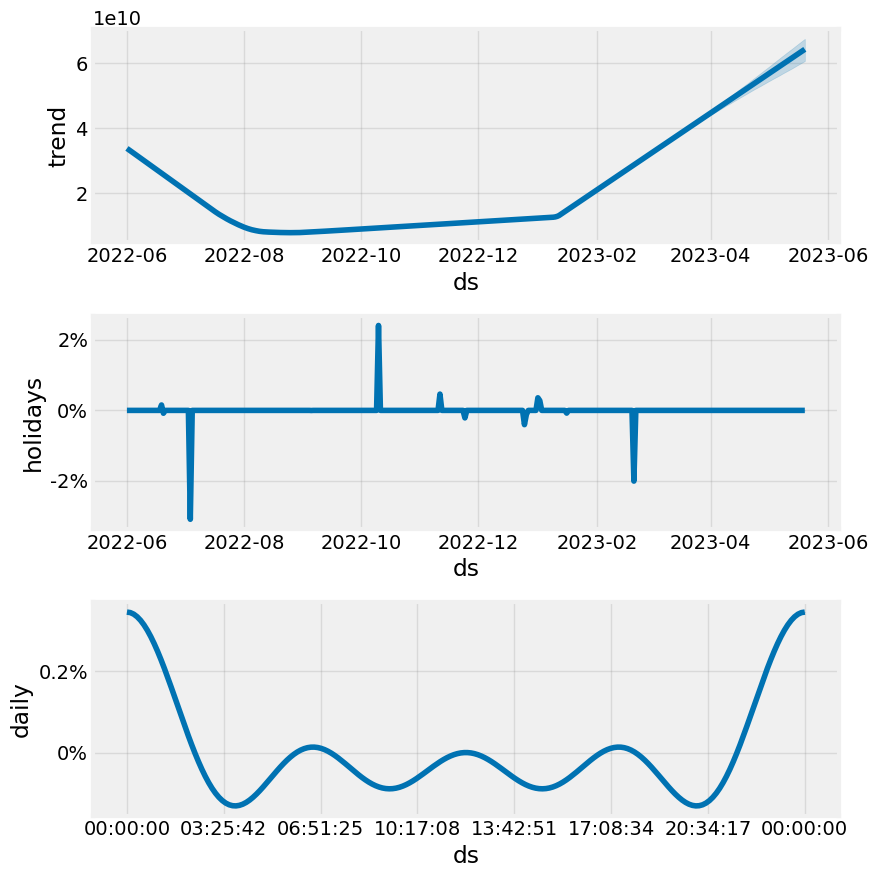

In [173]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

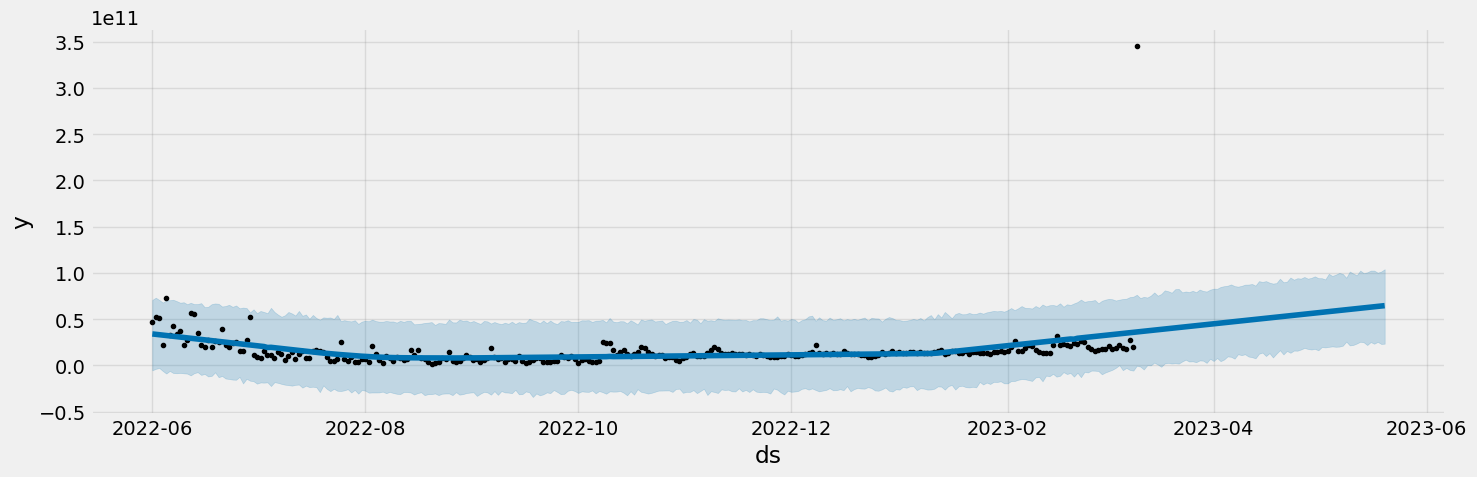

In [174]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [175]:
X_tst_final= final_model.predict(test)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
64,2023-05-14,6.210734e+10,2.398255e+10,1.021525e+11
65,2023-05-15,6.250798e+10,2.556614e+10,1.008021e+11
66,2023-05-16,6.290863e+10,2.463329e+10,1.023338e+11
67,2023-05-17,6.330927e+10,2.464406e+10,1.019361e+11
68,2023-05-18,6.370992e+10,2.517519e+10,1.039683e+11
69,2023-05-19,6.411057e+10,2.777762e+10,1.037176e+11
70,2023-05-20,6.451121e+10,2.156300e+10,1.051106e+11


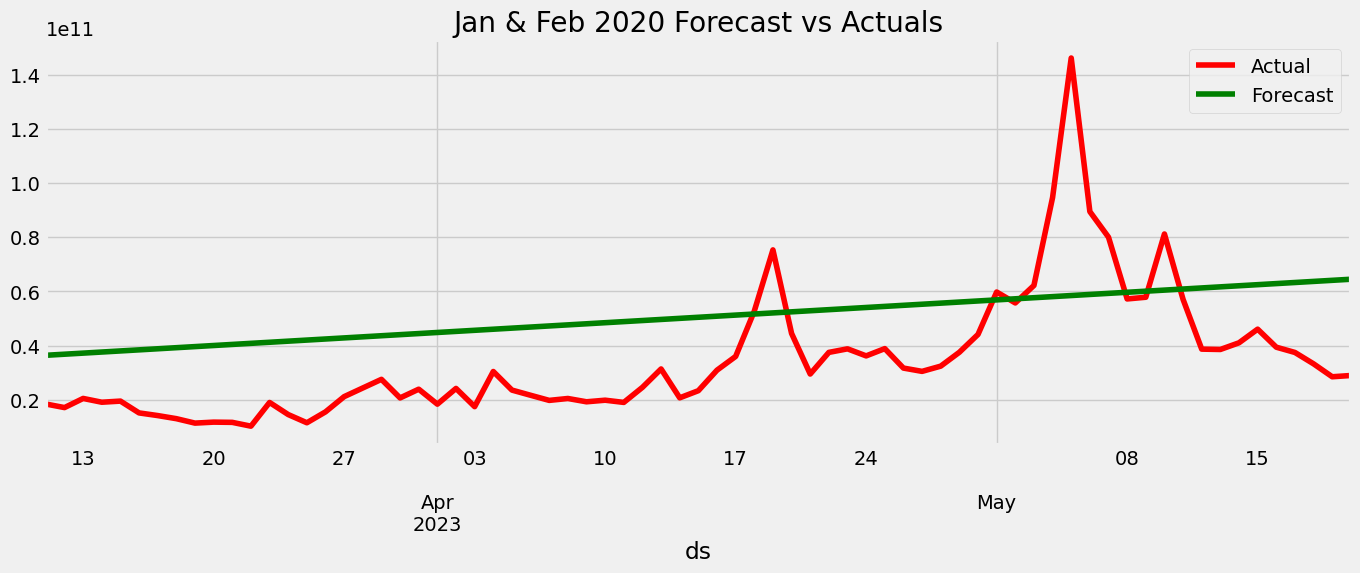

In [176]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [170]:
MAPE = mean_absolute_percentage_error(test['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 130.16906473577552
